# Markov Chain for Campaign Attribution POC
v2  
* ALL campaigns
* New conversion definition (activated purchase)
* New touchpoints (purchase)
* CA only

Data generated here:  
https://console.cloud.google.com/bigquery?sq=564585695625:e72b728feab349bc9602ec7b57f76172

In [1]:
import mta
import pandas as pd
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from datetime import datetime

# if you haven't alreadya GCP authenticated run !gcloud auth login
os.environ['GOOGLE_APPLICATION_CREDENTIALS']=f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json" 

Visit http://www.channelattribution.net for more information about ChannelAttribution


Information about MTA module  
https://bitbucket.org/wx_rds/mta/src/50cd3c3f2469/?at=master  
https://bytebucket.org/wx_rds/mta/wiki/_build/latex/mta.pdf?token=ed3f93f21d7e08c5a92ba0abba35888f63412a54&rev=599fd6872540e9a4945b968e0f02a87c9fc15ea5  
https://www.channelattribution.net/assets/files/ChannelAttributionWhitePaper-0536c269c4725179d4a0d8b8ec2f0fac.pdf

## MC POC data

In [2]:
# not working since updated MTA module's conda env
# df_test = pd.read_csv('gs://wx-personal/AndrewLau/nash/MC_POC/MC_input_with_all_camp.csv')

In [3]:
# alternative to reading from GCP directly into pandas dataframe
# !gsutil cp gs://wx-personal/AndrewLau/nash/MC_POC/MC_input_with_all_camp.csv 02_data/MC_input_with_all_camp.csv
!gsutil cp gs://wx-personal/AndrewLau/nash/MC_POC/MCPOC_input_000000000000.csv 02_data/MC_input_with_all_camp.csv

df = pd.read_csv('02_data/MC_input_with_all_camp.csv')
# !rm 02_data/MC_input_with_act_redemp.csv

Copying gs://wx-personal/AndrewLau/nash/MC_POC/MCPOC_input_000000000000.csv...
\ [1 files][367.0 MiB/367.0 MiB]                                                
Operation completed over 1 objects/367.0 MiB.                                    


In [4]:
# alternative to reading from GCP directly into pandas dataframe
!gsutil cp gs://wx-personal/AndrewLau/nash/MC_POC/campaign_info000000000000.csv 02_data/campaign_info000000000000.csv
campaign_info = pd.read_csv('02_data/campaign_info000000000000.csv')
# !rm 02_data/MC_input_with_act_redemp.csv

Copying gs://wx-personal/AndrewLau/nash/MC_POC/campaign_info000000000000.csv...
/ [1 files][  8.1 KiB/  8.1 KiB]                                                
Operation completed over 1 objects/8.1 KiB.                                      


In [5]:
# NA inc sales causes NAN for CA
print("number of NA inc sales", sum(df.inc_sales.isnull()))
df.loc[:, "inc_sales"] = df.loc[:, "inc_sales"].fillna(0)
print("number of NA inc sales after filling in", sum(df.inc_sales.isnull()))

number of NA inc sales 587079
number of NA inc sales after filling in 0


In [6]:
df.head(15)

wk_start_date                                               path  num_crn  \
0     2021-02-08  CVM-4076_unactivated_purchase > ENG-3355_unact...       11   
1     2021-02-08  CVM-0007_unactivated_purchase > CAT-4105_unact...      219   
2     2021-02-08  CVM-0108_unactivated_purchase > OSP-4102_unact...       39   
3     2021-02-08  CVM-0007_unactivated_purchase > OSP-2373_unact...       80   
4     2021-02-08  ENG-3355_unactivated_purchase > OSP-4102_unact...       36   
5     2021-02-08  OSP-2373_unactivated_purchase > CAT-4031_unact...      142   
6     2021-02-08  CAT-4031_unactivated_purchase > CAT-4003_unact...       18   
7     2021-02-08  CAT-4003_unactivated_purchase > CAT-4031_unact...       42   
8     2021-02-08  CAT-4003_unactivated_purchase > CAT-4031_unact...       13   
9     2021-02-08  ENG-3355_unactivated_purchase > CAT-4031_unact...       33   
10    2021-02-08  CAT-4003_activation > CNA-0005_redemption > OS...        5   
11    2021-02-08  OSP-2373_unactivated_purchase > CVM-3529_unact...      132   
12    2021-02-08  CAT-4031_unactivated_purchase > CAT-4105_unact...       73   
13    2021-02-08  CNA-0005_redemption > CVM-4076_unactivated_pur...       12   
14    2021-02-08  OSP-2373_activation > OSP-2373_redemption > OS...       13   

     inc_sales  conversion_inc_sales_positive  \
0    49.565455                              1   
1   113.579091                              6   
2    63.623636                              1   
3    37.932727                              1   
4  -102.698182                              0   
5    26.141818                              2   
6   354.639091                              2   
7   293.997273                              2   
8   202.691818                              1   
9   -35.946364                              1   
10 -131.607273                              0   
11  518.003636                              5   
12  131.573636                              1   
13    7.447273                              1   
14 -417.160909                              0   

    non_conversion_inc_sales_positive  conversion_act_purchase  \
0                                  10                       11   
1                                 213                      219   
2                                  38                       39   
3                                  79                       80   
4                                  36                       36   
5                                 140                      142   
6                                  16                       18   
7                                  40                       42   
8                                  12                       13   
9                                  32                       33   
10                                  5                        0   
11                                127                      132   
12                                 72                       73   
13                                 11                       12   
14                                 13                       13   

    non_conversion_act_purchase  
0                             0  
1                             0  
2                             0  
3                             0  
4                             0  
5                             0  
6                             0  
7                             0  
8                             0  
9                             0  
10                            5  
11                            0  
12                            0  
13                            0  
14                            0

<AxesSubplot:>

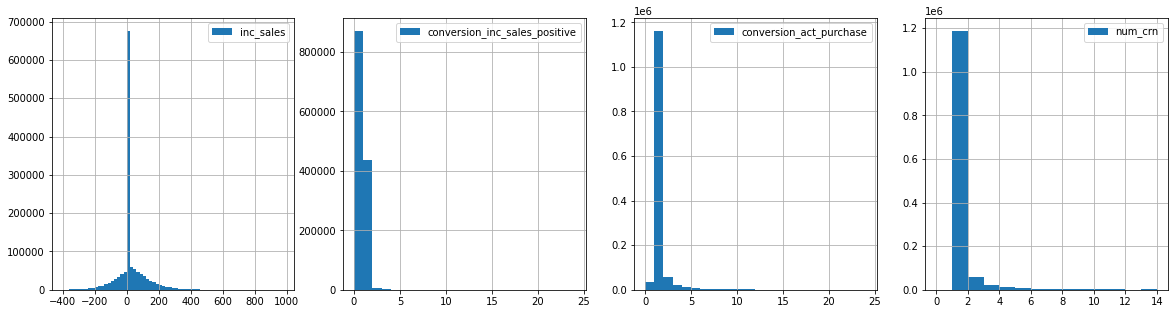

In [7]:
plt.subplot(1, 4, 1)
df.inc_sales.hist(figsize=(20,5), bins=[20 * x for x in range(-20, 50)], legend=1)
plt.subplot(1, 4, 2)
df.conversion_inc_sales_positive.hist(figsize=(20,5), bins=[1 * x for x in range(0, 25)], legend=1)
plt.subplot(1, 4, 3)
df.conversion_act_purchase.hist(figsize=(20,5), bins=[1 * x for x in range(0, 25)], legend=1)
plt.subplot(1, 4, 4)
df.num_crn.hist(figsize=(20,5), bins=[1 * x for x in range(0, 15)], legend=1)

### Testing new Channel Attribution Format

In [8]:
start_time = time.time()
ca_conv_pos_inc_sales = mta.ca_from_journey(cj_df=df,
                                       var_path='path',
                                       var_conv='conversion_inc_sales_positive',
                                       var_null='non_conversion_inc_sales_positive',
                                       var_value='inc_sales',
                                       order=1)
print("run time", time.time() - start_time)
ca_conv_pos_inc_sales .sort_values("channel_name")
# ca_conv_pos_inc_sales ['normalised_conversion_value'] = pd.Series(["{0:.2f}%".format(val * 100) for val in ca_conv_pos_inc_sales ['normalised_conversion_value']], index = ca_conv_pos_inc_sales .index)
# ca_conv_pos_inc_sales.loc['Column_Total'] = ca_conv_pos_inc_sales.sum(numeric_only=True, axis=0)
pd.options.display.max_rows = 100
ca_conv_pos_inc_sales.sort_values("channel_name", inplace=True)
pd.options.display.max_rows = 25
ca_conv_pos_inc_sales 

Number of simulations: 100000 - Reaching convergence (wait...): 8.14% > 5.00%
Number of simulations: 150000 - Reaching convergence (wait...): 7.02% > 5.00%
Number of simulations: 225000 - Reaching convergence (wait...): 5.62% > 5.00%
Number of simulations: 337500 - Convergence reached: 4.69% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (32) is reached: 99.95%
run time 36.84482741355896


channel_name  total_conversions  \
41      CAT-4003_activated_purchase       10002.444589   
13              CAT-4003_activation       16630.702084   
16              CAT-4003_redemption        8277.132094   
9     CAT-4003_unactivated_purchase       12470.296638   
46      CAT-4031_activated_purchase       12077.187462   
29              CAT-4031_activation       12426.617841   
47              CAT-4031_redemption        1648.874599   
8     CAT-4031_unactivated_purchase       17995.664500   
35      CAT-4105_activated_purchase       12262.822351   
27              CAT-4105_activation       13180.077095   
66              CAT-4105_redemption       10952.458431   
3     CAT-4105_unactivated_purchase       17668.073520   
14              CNA-0005_redemption       11476.603999   
7     CNA-0005_unactivated_purchase       22188.829044   
25      CVM-0007_activated_purchase        3472.464388   
23              CVM-0007_activation        3483.384087   
24              CVM-0007_redemption        3123.034009   
4     CVM-0007_unactivated_purchase       13103.639199   
85      CVM-0056_activated_purchase          87.357595   
83              CVM-0056_activation           0.000000   
84              CVM-0056_redemption           0.000000   
51    CVM-0056_unactivated_purchase         109.196993   
44      CVM-0106_activated_purchase        3068.435513   
43              CVM-0106_activation        2566.129343   
74              CVM-0106_redemption         513.225869   
20    CVM-0106_unactivated_purchase        8419.088186   
48      CVM-0108_activated_purchase        2216.698965   
40              CVM-0108_activation        1758.071593   
62              CVM-0108_redemption         294.831882   
5     CVM-0108_unactivated_purchase        9150.708041   
63      CVM-3510_activated_purchase         371.269777   
37              CVM-3510_activation         251.153085   
36              CVM-3510_redemption         338.510679   
45    CVM-3510_unactivated_purchase         829.897149   
53      CVM-3529_activated_purchase        1441.400312   
52              CVM-3529_activation         709.780457   
58              CVM-3529_redemption         666.101659   
17    CVM-3529_unactivated_purchase        8146.095702   
31      CVM-4076_activated_purchase        8932.314054   
26              CVM-4076_activation       10024.283988   
49              CVM-4076_redemption        1310.363920   
0     CVM-4076_unactivated_purchase       10482.911360   
68              ENG-3355_redemption         709.780457   
1     ENG-3355_unactivated_purchase       41232.784681   
30            ONL-3999_B_redemption          10.919699   
57  ONL-3999_B_unactivated_purchase         283.912183   
72      OSP-0008_activated_purchase        1998.304978   
22              OSP-0008_activation        2871.880925   
59              OSP-0008_redemption        1244.845724   
12    OSP-0008_unactivated_purchase        9860.488498   
19      OSP-2373_activated_purchase       22112.391149   
15              OSP-2373_activation       26906.139156   
18              OSP-2373_redemption       19316.948120   
2     OSP-2373_unactivated_purchase       41265.543779   
73      OSP-4034_activated_purchase        1517.838207   
55              OSP-4034_activation        2784.523330   
69              OSP-4034_redemption         163.795490   
38    OSP-4034_unactivated_purchase        2478.771749   
76      OSP-4053_activated_purchase         906.335045   
65              OSP-4053_activation        1987.385279   
71              OSP-4053_redemption         141.956091   
39    OSP-4053_unactivated_purchase        3133.953709   
78      OSP-4054_activated_purchase         928.174443   
54              OSP-4054_activation        2009.224677   
61              OSP-4054_redemption         120.116693   
10    OSP-4054_unactivated_purchase        2424.173252   
64      OSP-4079_activated_purchase        3712.697773   
28              OSP-4079_activation        3385.106793   
75              OSP-4

In [9]:
start_time = time.time()
ca_conv_act_purchase = mta.ca_from_journey(cj_df=df,
                                       var_path='path',
                                       var_conv='conversion_act_purchase',
                                       var_null='non_conversion_act_purchase',
                                       var_value='inc_sales',
                                       order=1)
print("run time", time.time() - start_time)
ca_conv_act_purchase .sort_values("channel_name")
# ca_conv_act_purchase ['normalised_conversion_value'] = pd.Series(["{0:.2f}%".format(val * 100) for val in ca_conv_act_purchase ['normalised_conversion_value']], index = ca_conv_act_purchase .index)
# ca_conv_act_purchase.loc['Column_Total'] = ca_conv_act_purchase.sum(numeric_only=True, axis=0)
pd.options.display.max_rows = 100
ca_conv_act_purchase.sort_values("channel_name", inplace=True)
pd.options.display.max_rows = 25
ca_conv_act_purchase 

Number of simulations: 100000 - Convergence reached: 3.20% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (32) is reached: 99.95%
run time 36.703617095947266


channel_name  total_conversions  \
41      CAT-4003_activated_purchase       70278.028405   
13              CAT-4003_activation      110970.929351   
16              CAT-4003_redemption       49450.953118   
9     CAT-4003_unactivated_purchase      130089.116410   
46      CAT-4031_activated_purchase       78395.247492   
29              CAT-4031_activation       81278.996378   
47              CAT-4031_redemption        4485.831600   
8     CAT-4031_unactivated_purchase      188832.149272   
35      CAT-4105_activated_purchase       68141.918120   
27              CAT-4105_activation       82347.051521   
66              CAT-4105_redemption       39197.623746   
3     CAT-4105_unactivated_purchase      183064.651500   
14              CNA-0005_redemption       56072.895004   
7     CNA-0005_unactivated_purchase      193852.008443   
25      CVM-0007_activated_purchase       23176.796602   
23              CVM-0007_activation       22856.380059   
24              CVM-0007_redemption       13457.494801   
4     CVM-0007_unactivated_purchase      220339.775988   
85      CVM-0056_activated_purchase         106.805514   
83              CVM-0056_activation         106.805514   
84              CVM-0056_redemption           0.000000   
51    CVM-0056_unactivated_purchase        1922.499257   
44      CVM-0106_activated_purchase       15273.188544   
43              CVM-0106_activation       16234.438173   
74              CVM-0106_redemption        2990.554400   
20    CVM-0106_unactivated_purchase      115243.149923   
48      CVM-0108_activated_purchase       12496.245172   
40              CVM-0108_activation       13671.105830   
62              CVM-0108_redemption        1281.666172   
5     CVM-0108_unactivated_purchase      158819.799755   
63      CVM-3510_activated_purchase        2029.304772   
37              CVM-3510_activation        3524.581972   
36              CVM-3510_redemption        2456.526829   
45    CVM-3510_unactivated_purchase       15700.410601   
53      CVM-3529_activated_purchase        5981.108800   
52              CVM-3529_activation        5126.664686   
58              CVM-3529_redemption        2029.304772   
17    CVM-3529_unactivated_purchase      130089.116410   
31      CVM-4076_activated_purchase       58102.199776   
26              CVM-4076_activation       61306.365205   
49              CVM-4076_redemption        7583.191515   
0     CVM-4076_unactivated_purchase      120476.620124   
68              ENG-3355_redemption        5660.692258   
1     ENG-3355_unactivated_purchase      315930.711281   
30            ONL-3999_B_redemption         640.833086   
57  ONL-3999_B_unactivated_purchase        3310.970943   
72      OSP-0008_activated_purchase       11641.801058   
22              OSP-0008_activation       14632.355458   
59              OSP-0008_redemption        3524.581972   
12    OSP-0008_unactivated_purchase       89930.243035   
19      OSP-2373_activated_purchase      124428.424152   
15              OSP-2373_activation      164480.492013   
18              OSP-2373_redemption       83842.328721   
2     OSP-2373_unactivated_purchase      461933.849321   
73      OSP-4034_activated_purchase        9932.912829   
55              OSP-4034_activation       24244.851745   
69              OSP-4034_redemption        3097.359915   
38    OSP-4034_unactivated_purchase       22001.935945   
76      OSP-4053_activated_purchase        6087.914315   
65              OSP-4053_activation       13243.883772   
71              OSP-4053_redemption         961.249629   
39    OSP-4053_unactivated_purchase       28089.850259   
78      OSP-4054_activated_purchase        6728.747401   
54              OSP-4054_activation       15807.216115   
61              OSP-4054_redemption         213.611029   
10    OSP-4054_unactivated_purchase       26594.573059   
64      OSP-4079_activated_purchase       19545.409116   
28              OSP-4079_activation       24138.046230   
75              OSP-4

# Results

In [10]:
results = ca_conv_pos_inc_sales.join(ca_conv_act_purchase.loc[:, ["total_conversions", "total_conversion_value", "normalised_conversion_value"]], rsuffix='_act_purchase')
results.sort_values("channel_name", inplace=True)
results.insert(0, "campaign", results.channel_name.str.slice(0, 8))
results.loc['Column_Total'] = results.sum(numeric_only=True, axis=0)

for col in ["total_conversions", "total_conversion_value", "normalised_conversion_value", "total_conversions_act_purchase",
            "total_conversion_value_act_purchase", "normalised_conversion_value_act_purchase"]:
    if col.find("normalised") > -1:
        results.loc[:, col] = (results.loc[:, col] * 100).round(2)
    else:
        results.loc[:, col] = results.loc[:, col].round(2)

results.to_csv("04_results/results_" + datetime.today().strftime('%Y_%m_%d__%H_%M') + ".csv")

pd.options.display.max_rows = 25
results

campaign                     channel_name  total_conversions  \
41            CAT-4003      CAT-4003_activated_purchase           10002.44   
13            CAT-4003              CAT-4003_activation           16630.70   
16            CAT-4003              CAT-4003_redemption            8277.13   
9             CAT-4003    CAT-4003_unactivated_purchase           12470.30   
46            CAT-4031      CAT-4031_activated_purchase           12077.19   
29            CAT-4031              CAT-4031_activation           12426.62   
47            CAT-4031              CAT-4031_redemption            1648.87   
8             CAT-4031    CAT-4031_unactivated_purchase           17995.66   
35            CAT-4105      CAT-4105_activated_purchase           12262.82   
27            CAT-4105              CAT-4105_activation           13180.08   
66            CAT-4105              CAT-4105_redemption           10952.46   
3             CAT-4105    CAT-4105_unactivated_purchase           17668.07   
14            CNA-0005              CNA-0005_redemption           11476.60   
7             CNA-0005    CNA-0005_unactivated_purchase           22188.83   
25            CVM-0007      CVM-0007_activated_purchase            3472.46   
23            CVM-0007              CVM-0007_activation            3483.38   
24            CVM-0007              CVM-0007_redemption            3123.03   
4             CVM-0007    CVM-0007_unactivated_purchase           13103.64   
85            CVM-0056      CVM-0056_activated_purchase              87.36   
83            CVM-0056              CVM-0056_activation               0.00   
84            CVM-0056              CVM-0056_redemption               0.00   
51            CVM-0056    CVM-0056_unactivated_purchase             109.20   
44            CVM-0106      CVM-0106_activated_purchase            3068.44   
43            CVM-0106              CVM-0106_activation            2566.13   
74            CVM-0106              CVM-0106_redemption             513.23   
20            CVM-0106    CVM-0106_unactivated_purchase            8419.09   
48            CVM-0108      CVM-0108_activated_purchase            2216.70   
40            CVM-0108              CVM-0108_activation            1758.07   
62            CVM-0108              CVM-0108_redemption             294.83   
5             CVM-0108    CVM-0108_unactivated_purchase            9150.71   
63            CVM-3510      CVM-3510_activated_purchase             371.27   
37            CVM-3510              CVM-3510_activation             251.15   
36            CVM-3510              CVM-3510_redemption             338.51   
45            CVM-3510    CVM-3510_unactivated_purchase             829.90   
53            CVM-3529      CVM-3529_activated_purchase            1441.40   
52            CVM-3529              CVM-3529_activation             709.78   
58            CVM-3529              CVM-3529_redemption             666.10   
17            CVM-3529    CVM-3529_unactivated_purchase            8146.10   
31            CVM-4076      CVM-4076_activated_purchase            8932.31   
26            CVM-4076              CVM-4076_activation           10024.28   
49            CVM-4076              CVM-4076_redemption            1310.36   
0             CVM-4076    CVM-4076_unactivated_purchase           10482.91   
68            ENG-3355              ENG-3355_redemption             709.78   
1             ENG-3355    ENG-3355_unactivated_purchase           41232.78   
30            ONL-3999            ONL-3999_B_redemption              10.92   
57            ONL-3999  ONL-3999_B_unactivated_purchase             283.91   
72            OSP-0008      OSP-0008_activated_purchase            1998.30   
22            OSP-0008              OSP-0008_activation            2871.88   
59            OSP-0008              OSP-0008_redemption            1244.85   
12            OSP-0008    OSP-0008_unactivated_purchase            9860.49   
19            OSP-2373      OSP-2373

In [14]:
results_grouped = results.groupby("campaign").sum()
results_grouped.loc['Column_Total'] = results_grouped.sum(numeric_only=True, axis=0)
results_grouped.to_csv("04_results/results_grouped_" + datetime.today().strftime('%Y_%m_%d__%H_%M') + ".csv")
results_grouped = results_grouped.join(campaign_info.loc[:, ["cmpgn_code", "description", "cmpgn_type", "cmpgn_id"]].set_index("cmpgn_code"), on="campaign")
pd.options.display.max_rows = 50
results_grouped

total_conversions  total_conversion_value  \
campaign                                                  
CAT-4003               47380.57              2565500.28   
CAT-4031               44148.34              2397583.00   
CAT-4105               54063.43              2920849.61   
CNA-0005               33665.43              1882524.44   
CVM-0007               23182.51              1253474.62   
CVM-0056                 196.56                 6296.43   
CVM-0106               14566.89               739346.17   
CVM-0108               13420.31               663918.33   
CVM-3510                1790.83                94858.98   
CVM-3529               10963.38               593694.10   
CVM-4076               30749.86              1639082.31   
ENG-3355               41942.56              2299995.85   
ONL-3999                 294.83                14918.01   
OSP-0008               15975.52               888072.03   
OSP-2373              109601.02              5913292.98   
OSP-4034                6944.93               325604.62   
OSP-4053                6169.64               328468.57   
OSP-4054                5481.68               290966.96   
OSP-4079               13955.38               797484.19   
OSP-4102               12295.58               598529.33   
PBU-4073                5940.32               357410.96   
TBR-4103                7556.44               385058.18   
TBR-4303                3810.97               183910.75   
Column_Total          504096.98             27140840.70   

              normalised_conversion_value  total_conversions_act_purchase  \
campaign                                                                    
CAT-4003                             9.45                       360789.03   
CAT-4031                             8.83                       352992.23   
CAT-4105                            10.76                       372751.24   
CNA-0005                             6.93                       249924.91   
CVM-0007                             4.62                       279830.45   
CVM-0056                             0.02                         2136.12   
CVM-0106                             2.72                       149741.33   
CVM-0108                             2.44                       186268.83   
CVM-3510                             0.35                        23710.82   
CVM-3529                             2.18                       143226.19   
CVM-4076                             6.04                       247468.38   
ENG-3355                             8.47                       321591.40   
ONL-3999                             0.05                         3951.80   
OSP-0008                             3.27                       119728.98   
OSP-2373                            21.78                       834685.09   
OSP-4034                             1.19                        59277.06   
OSP-4053                             1.21                        48382.89   
OSP-4054                             1.07                        49344.15   
OSP-4079                             2.94                       100397.19   
OSP-4102                             2.20                        84055.95   
PBU-4073                             1.33                        32682.49   
TBR-4103                             1.42                        55538.87   
TBR-4303                             0.68                        19972.63   
Column_Total                        99.95                      4098448.03   

              total_conversion_value_act_purchase  \
campaign                                            
CAT-4003                               2382714.32   
CAT-4031                               2472085.50   
CAT-4105                               3340412.07   
CNA-0005                               1425715.31   
CVM-0007                               1249042.01   
CVM-0056                                -13005.93   
CVM-0106                                877061.22   